About:

Assignment 1: Distributional Word Representations

Class: CS221.N11.KHTN

Group 6

Members:
- Nguyễn Duy Đạt (20520435)
- Trần Hữu Khoa (20520222)
- Huỳnh Hoàng Vũ (20520864)
- Lê Thế Việt (20520093)

Date: 19/10/2022

# Import libaries and download datasets

In [ ]:
import numpy as np
import pandas as pd
import copy
import heapq
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from io import open
from collections import Counter, defaultdict
from math import sqrt

from scipy.sparse import lil_matrix, coo_matrix
from scipy.sparse import csr_matrix
from scipy import stats
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr
from scipy import spatial


%matplotlib inline

In [ ]:
!gdown --id 1trtwTtde-YUVsMOOgrw_jDAlrkL1FyzR
!gdown --id 1HGWXH9pg_BV-EIOXNWx2sL9AqvvanTHa
!gdown --id 13qxlHq7A3UBIwq6Odkbj3yOGasxcCf8w

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1trtwTtde-YUVsMOOgrw_jDAlrkL1FyzR
To: /content/31190-a1-files.zip
100% 242k/242k [00:00<00:00, 71.1MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1HGWXH9pg_BV-EIOXNWx2sL9AqvvanTHa
To: /content/wiki-0.1percent.txt.zip
100% 4.45M/4.45M [00:00<00:00, 28.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloa

In [ ]:
!unzip -q /content/31190-a1-files.zip
!unzip -q /content/wiki-0.1percent.txt.zip
!unzip -q /content/wiki-1percent.txt.zip

# 1. Required Tasks (50 points total)


## 1.1 Distributional Counting (20 points)


In [ ]:
V = open('31190-a1-files/vocab-wordsim.txt').read().split('\n')[:-1] 
V_C = open('31190-a1-files/vocab-25k.txt').read().split('\n')[:-1] 

V_dict = {word.strip(): idx for idx, word in enumerate(V)}   
V_C_dict = {word.strip(): idx for idx, word in enumerate(V_C)}

corpus = open('/content/wiki-1percent.txt').read().split('\n')[:-1] 

In [ ]:
def gen_words_context (corpus, V_dict, V_C_dict, V, V_C, window_value):
  # print(len(V_dict))
  count = np.zeros((len(V), len(V_C)), dtype=float)
  V_dim_words = V_dict.keys()
  V_C_dim_words = V_C_dict.keys()
  for line in tqdm(corpus):
    cleaned = line.strip()
    line = "<s> " + cleaned + " </s>"
    sentence_list = line.split()
    for idx, word in enumerate(sentence_list):
      if idx > 0 and idx < len(sentence_list) - 1:
        if word in V_dim_words: 
          for context_word in sentence_list[max(idx-window_value,0):idx] + sentence_list[idx+1:min(idx+window_value+1,len(sentence_list))]:
            if context_word in V_C_dim_words:
              count[V_dict[word]][V_C_dict[context_word]] += 1

  return count

In [ ]:
def calculate_spearmen(wc_mtx, V_dict, human_dict):
  wc_sim_list, human_sim_list = [], []
  for key, value in human_dict.items():
    human_sim_list.append(value)
    if key[0] not in V_dict or key[1] not in V_dict:
      wc_sim_list.append(0)
    else:
      word_1_vec = wc_mtx[V_dict[key[0]], :]
      word_2_vec = wc_mtx[V_dict[key[1]], :]
      wc_sim_list.append(1 - cosine(word_1_vec, word_2_vec))

  return spearmanr(wc_sim_list, human_sim_list, axis=None).correlation

def read_annotation(path):
  d = {}
  with open(path) as document:
      lst = list(document)
      for i in lst[1:]:
          clean_lst =i.strip().split("\t")
          key=tuple(clean_lst[:2])
          value = float(clean_lst[-1])
          d[key] = value
  return d

In [ ]:
C_window_3 = gen_words_context(corpus, V_dict, V_C_dict, V, V_C, 3)

100%|██████████| 997898/997898 [00:24<00:00, 40394.45it/s]


In [ ]:
men_window_3 = calculate_spearmen(C_window_3, V_dict, read_annotation('/content/31190-a1-files/men.txt'))
simlex_window_3 = calculate_spearmen(C_window_3, V_dict, read_annotation('/content/31190-a1-files/simlex-999.txt'))
print(men_window_3)
print(simlex_window_3)

0.22433852567075044
0.06134632093956428


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


## 1.2 Computing PMIs (10 points)

$O(n^2) solution$

In [ ]:
def get_C_pmi(C, V, V_C):
  C_pmi = np.zeros((C.shape[0], C.shape[1]), dtype=float)
  p_ij, p_i, p_j = C / C.sum(), C.sum(axis=1) / C.sum(), C.sum(axis=0) / C.sum()

  for i in tqdm(range(len(V))):
    for j in range(len(V_C)):
      C_pmi[i, j] = np.log2(p_ij[i, j] / (p_i[i] * p_j[j]))
  
  C_pmi = np.where(C_pmi > 0, C_pmi, 0)
  
  return C_pmi

In [ ]:
C_pmi = get_C_pmi(C_window_3, V, V_C)

  0%|          | 0/1577 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
100%|██████████| 1577/1577 [02:33<00:00, 10.30it/s]


In [ ]:
men_pmi_3 = calculate_spearmen(C_pmi, V_dict, read_annotation('/content/31190-a1-files/men.txt'))
simlex_pmi_3 = calculate_spearmen(C_pmi, V_dict, read_annotation('/content/31190-a1-files/simlex-999.txt'))
print(men_pmi_3)
print(simlex_pmi_3)

0.5300999199603679
0.21272884825362404


Faster solution

In [ ]:
def double_sum(array):
    """
    sum over all rows first and then sum those sums
    """
    return np.sum(np.einsum("ij->i", array))

def gen_joint_probs(array):
    """
    For a given array, generate the joint distribution array
    """
    return array/double_sum(array)

def row_probs(array):
    """
    This function represents p(w) for each row.
    """
    return np.einsum("ij-> i", array)

def col_probs(array):
    """
    This function represents p(context) for each column.
    """
    return np.einsum("ij->j", array)

def gen_PMI(array, smoothing=False, smooth_const=2):
    """
    For a given input array, generate the PMI matrix.
    
    To activate laplace smoothing, set smoothing to True.
    
    Default smoothing set to False. If True, smoothing factor=2
    """
    if smoothing:
        array = array + smooth_const

    context_matrix = gen_joint_probs(array)
    p_w = row_probs(context_matrix)
    p_c = col_probs(context_matrix)
    
    PMI_mtx = context_matrix/p_w[:, np.newaxis]
    PMI_mtx = np.divide(PMI_mtx, p_c)
    PMI_mtx[np.isnan(PMI_mtx)] = 0 
    PMI_mtx[PMI_mtx != 0] = np.log2(PMI_mtx[PMI_mtx!=0])
    PMI_mtx[PMI_mtx < 0] = 0 # remove negative values - PPMI
    
    return PMI_mtx

In [ ]:
C_PMI_3 = gen_PMI(C_window_3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
men_pmi_3 = calculate_spearmen(C_PMI_3, V_dict, read_annotation('/content/31190-a1-files/men.txt'))
simlex_pmi_3 = calculate_spearmen(C_PMI_3, V_dict, read_annotation('/content/31190-a1-files/simlex-999.txt'))
print(men_pmi_3)
print(simlex_pmi_3)

0.5300999199603679
0.21272884825362404


## 1.3 Experimentation (5 points)

### Window size = 1

In [ ]:
C_window_1 = gen_words_context(corpus, V_dict, V_C_dict, V, V_C, 1)
men_window_1 = calculate_spearmen(C_window_1, V_dict, read_annotation('/content/31190-a1-files/men.txt'))
simlex_window_1 = calculate_spearmen(C_window_1, V_dict, read_annotation('/content/31190-a1-files/simlex-999.txt'))

C_PMI_1 = gen_PMI(C_window_1)
men_pmi_1 = calculate_spearmen(C_PMI_1, V_dict, read_annotation('/content/31190-a1-files/men.txt'))
simlex_pmi_1 = calculate_spearmen(C_PMI_1, V_dict, read_annotation('/content/31190-a1-files/simlex-999.txt'))

100%|██████████| 997898/997898 [00:13<00:00, 76469.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
print('Word-Context Matrix Spearmen Correlation with MEN:', men_window_1)
print('Word-Context Spearmen Correlation with SimLex-999', simlex_window_1)

print('PMI Matrix Spearmen Correlation with MEN:', men_pmi_1)
print('PMI Matrix Spearmen Correlation with SimLex-999:', simlex_pmi_1)

Word-Context Matrix Spearmen Correlation with MEN: 0.20992265447069547
Word-Context Spearmen Correlation with SimLex-999 0.07753059821419862
PMI Matrix Spearmen Correlation with MEN: 0.46582757219242
PMI Matrix Spearmen Correlation with SimLex-999: 0.2729154998130331


### Window size = 3

In [ ]:
print('Word-Context Matrix Spearmen Correlation with MEN:', men_window_3)
print('Word-Context Spearmen Correlation with SimLex-999', simlex_window_3)

print('PMI Matrix Spearmen Correlation with MEN:', men_pmi_3)
print('PMI Matrix Spearmen Correlation with SimLex-999:', simlex_pmi_3)

Word-Context Matrix Spearmen Correlation with MEN: 0.22433852567075044
Word-Context Spearmen Correlation with SimLex-999 0.06134632093956428
PMI Matrix Spearmen Correlation with MEN: 0.5300999199603679
PMI Matrix Spearmen Correlation with SimLex-999: 0.21272884825362404


### Window size = 6

In [ ]:
C_window_6 = gen_words_context(corpus, V_dict, V_C_dict, V, V_C, 6)
men_window_6 = calculate_spearmen(C_window_6, V_dict, read_annotation('/content/31190-a1-files/men.txt'))
simlex_window_6 = calculate_spearmen(C_window_6, V_dict, read_annotation('/content/31190-a1-files/simlex-999.txt'))

C_PMI_6 = gen_PMI(C_window_6)
men_pmi_6 = calculate_spearmen(C_PMI_6, V_dict, read_annotation('/content/31190-a1-files/men.txt'))
simlex_pmi_6 = calculate_spearmen(C_PMI_6, V_dict, read_annotation('/content/31190-a1-files/simlex-999.txt'))

100%|██████████| 997898/997898 [00:25<00:00, 38772.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
print('Word-Context Matrix Spearmen Correlation with MEN:', men_window_6)
print('Word-Context Spearmen Correlation with SimLex-999', simlex_window_6)

print('PMI Matrix Spearmen Correlation with MEN:', men_pmi_6)
print('PMI Matrix Spearmen Correlation with SimLex-999:', simlex_pmi_6)

Word-Context Matrix Spearmen Correlation with MEN: 0.23790636810978752
Word-Context Spearmen Correlation with SimLex-999 0.040553547139409986
PMI Matrix Spearmen Correlation with MEN: 0.5298494458448623
PMI Matrix Spearmen Correlation with SimLex-999: 0.16106567681754796


### Visualize

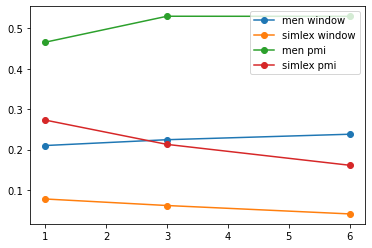

In [ ]:
# create data
men_window = [men_window_1, men_window_3, men_window_6]
simlex_window = [simlex_window_1, simlex_window_3, simlex_window_6]
men_pmi = [men_pmi_1, men_pmi_3, men_pmi_6]
simlex_pmi = [simlex_pmi_1, simlex_pmi_3, simlex_pmi_6]

window_size = [1,3,6]
# plot lines
plt.plot(window_size, men_window, linestyle='-', marker='o', label = "men window")
plt.plot(window_size, simlex_window, linestyle='-', marker='o', label = "simlex window")
plt.plot(window_size, men_pmi, linestyle='-', marker='o', label = "men pmi")
plt.plot(window_size, simlex_pmi, linestyle='-', marker='o', label = "simlex pmi")
plt.legend()
plt.show()

Discussion:

- Độ tương quan của spearmen cao hơn khi sử dụng PMI so với sử dụng word-context. Điều này có thể giải thích là PMI thể hiện sự liên quan các từ riêng biệt trong khi đó word-count chỉ đơn giản là đếm các từ.

- Tập dataset MEN luôn có độ tương quan spearmen cao hơn hẳn so với dataset ở mọi model bởi vì tập MEN dựa trên sự liên quan của các từ trong khi đó SimLex-999 dựa trên nghĩa của các từ 

## 1.4  Analysis (15 points)

### 1.4.1  Warm-up: Printing nearest neighbors (3 points)

In [ ]:
def nearest_neighbors(C, V_set, query_word, k=10):

    lst = []
    V = V_set.keys()
    
    if query_word not in V:
        return "This query does not exist in the vocabulary"
    
    query_vector = C[V_set[query_word], :].reshape(1,-1)
    
    for word in V:
        if word == query_word: #avoid having a cosine similarity of 1 with itself
            continue
        else:
            word_vector =  C[V_set[word], :].reshape(1,-1)
            sim_score = cosine_similarity(query_vector, word_vector)[0][0]
            lst.append(((query_word,word),sim_score))
    
    sorted_lst = sorted(lst, key=lambda x: x[1], reverse=True)
    
    return sorted_lst[:k]

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "monster")

[(('monster', 'dragon'), 0.08406638954612768),
 (('monster', 'snowman'), 0.06948443441741135),
 (('monster', 'creatures'), 0.06878143841529642),
 (('monster', 'zombie'), 0.06577166119330759),
 (('monster', 'moon'), 0.0644076677553301),
 (('monster', 'jar'), 0.06213759715282472),
 (('monster', 'scooter'), 0.06087203261016741),
 (('monster', 'clown'), 0.060583321914232616),
 (('monster', 'destruction'), 0.06055778151097803),
 (('monster', 'dirty'), 0.05833143422577799)]

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "monster")

[(('monster', 'man'), 0.11239489795010818),
 (('monster', 'dragon'), 0.1106493837355547),
 (('monster', 'dog'), 0.11035611136388004),
 (('monster', 'girl'), 0.10932083951920943),
 (('monster', 'night'), 0.10926984236464223),
 (('monster', 'movie'), 0.10678976290159214),
 (('monster', 'love'), 0.10432087451101044),
 (('monster', 'hero'), 0.10349134687461214),
 (('monster', 'boy'), 0.10289496510285681),
 (('monster', 'cat'), 0.1026999318879786)]

### 1.4.2  Part-of-speech tag similarity in nearest neighbors (7 points)

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "neighbors") # Noun

'This query does not exist in the vocabulary'

Hầu hết neighbors là danh từ trừ từ "nomadic" là tính từ

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "neighbors") # Noun

'This query does not exist in the vocabulary'

Đa số neighbors không phải là danh từ

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "questions") # Noun

'This query does not exist in the vocabulary'

Tất cả đều là danh từ

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "questions") # Noun

'This query does not exist in the vocabulary'

Chỉ có top 3 là danh từ

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "transported") # Verb

'This query does not exist in the vocabulary'

Tất cả đều là động từ, 9 từ ở dạng V-ed, 1 từ dạng V-ing. Một số từ V-ed có thể xem như tính từ.

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "transported") # Verb

'This query does not exist in the vocabulary'

Nhiều từ có thể được xem là danh từ hoặc động từ. Có thêm dạng động từ nguyên mẫu và dạng thêm s.

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "choosing") # Verb

'This query does not exist in the vocabulary'

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "choosing") # Verb

'This query does not exist in the vocabulary'

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "nearest") # Adjective

'This query does not exist in the vocabulary'

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "nearest") # Adjective

'This query does not exist in the vocabulary'

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "red") # Adjective

[(('red', 'blue'), 0.2507251524119875),
 (('red', 'white'), 0.24224082527621457),
 (('red', 'yellow'), 0.23348611677086958),
 (('red', 'black'), 0.22096817954539033),
 (('red', 'green'), 0.18656862223003445),
 (('red', 'pink'), 0.14212413125054302),
 (('red', 'dark'), 0.14116083684389552),
 (('red', 'grey'), 0.13087501896795933),
 (('red', 'orange'), 0.1298641336819239),
 (('red', 'purple'), 0.11324831827992236)]

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "red") # Adjective

[(('red', 'white'), 0.2958261377160541),
 (('red', 'blue'), 0.28204300808179217),
 (('red', 'black'), 0.27205099711059616),
 (('red', 'yellow'), 0.2717077695962567),
 (('red', 'green'), 0.2478956519596127),
 (('red', 'dark'), 0.21673158004357795),
 (('red', 'color'), 0.20177535138446287),
 (('red', 'brown'), 0.18798147656931585),
 (('red', 'large'), 0.18792456617966208),
 (('red', 'light'), 0.1850969547956831)]

Với query "red", có 6 từ cùng nhắm trong 2 kích thước window. Đó là các từ trong top 5 và từ "dark"

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "for") # Preposition

'This query does not exist in the vocabulary'

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "for") # Preposition

'This query does not exist in the vocabulary'

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "with") # Preposition

'This query does not exist in the vocabulary'

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "with") # Preposition

'This query does not exist in the vocabulary'

Kết luận
- Khi context window bằng một, các neighbor gần nghĩa và gần loại từ với query.
- Khi context window bằng sáu, các neighbor có liên quan đến query và ít cùng từ loại.

### 1.4.3  Words with multiple senses (5 points)

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "cell")

[(('cell', 'molecule'), 0.09928145975983417),
 (('cell', 'brain'), 0.09869517757572234),
 (('cell', 'lung'), 0.08450800704038597),
 (('cell', 'cancer'), 0.08425443085813719),
 (('cell', 'normal'), 0.08292697367378025),
 (('cell', 'plant'), 0.07936581199106123),
 (('cell', 'blood'), 0.07692113987941758),
 (('cell', 'disease'), 0.07559582850192856),
 (('cell', 'can'), 0.07221347844919906),
 (('cell', 'liver'), 0.06866923382726872)]

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "cell")

[(('cell', 'can'), 0.22709130449653295),
 (('cell', 'blood'), 0.21310900705834288),
 (('cell', 'brain'), 0.2066472333042203),
 (('cell', 'activity'), 0.1920220130520307),
 (('cell', 'cancer'), 0.17882546685858008),
 (('cell', 'different'), 0.17864141021679616),
 (('cell', 'molecule'), 0.17793049545894005),
 (('cell', 'disease'), 0.16832885168705722),
 (('cell', 'skin'), 0.16356679519936562),
 (('cell', 'body'), 0.16009298613648762)]

Cả 2 kích thước window, các neighbor đều liên quan đến sinh học

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "light")

[(('light', 'heavy'), 0.1391687540574776),
 (('light', 'fire'), 0.10601406403980551),
 (('light', 'bright'), 0.10344957151183123),
 (('light', 'dark'), 0.09381568317970057),
 (('light', 'water'), 0.09360462944277936),
 (('light', 'large'), 0.08932970992436358),
 (('light', 'sunlight'), 0.08870832892760544),
 (('light', 'lighting'), 0.08797302326701555),
 (('light', 'air'), 0.08406458462988466),
 (('light', 'small'), 0.08268490928598608)]

"heavy" là trái nghĩa với nhẹ, "dark" là trái nghĩa với "ánh sáng"

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "light")

[(('light', 'can'), 0.22897033486181728),
 (('light', 'water'), 0.20215755248553305),
 (('light', 'dark'), 0.19867969778536185),
 (('light', 'small'), 0.19067854538108842),
 (('light', 'color'), 0.19062148509712923),
 (('light', 'heavy'), 0.1905159130570544),
 (('light', 'different'), 0.18831159000280728),
 (('light', 'large'), 0.18818737080275355),
 (('light', 'red'), 0.1850969547956831),
 (('light', 'body'), 0.18499945492266368)]

Chỉ mỗi từ "dark" liên quan

In [ ]:
nearest_neighbors(C_PMI_1, V_dict, "well")

'This query does not exist in the vocabulary'

Đa số là các từ mang nghĩa tích cực, một từ trái nghĩa "poorly" và một từ "not" phủ định. "well" trong bối cảnh này mang nghĩa "tốt"

In [ ]:
nearest_neighbors(C_PMI_6, V_dict, "well")

'This query does not exist in the vocabulary'

Khá nhiều từ phổ biến, không có từ nào liên quan đến "well"

Kết luận
- Khi query word là các từ có nhiều nghĩa, các neigbor có thể đồng nghĩa, trái nghĩa, hoặc liên quan đến các nghĩa khác nhau của query.
- Đôi lúc các neigbor chỉ liên quan đến một nghĩa của query
- Khi window bằng 6, có trường hợp nhiều từ phổ biến không liên quan đến query xuất hiện

# 2. Extra Credit: Dimensionality Reduction (5 extra points possible)

In [ ]:
V2 = open('31190-a1-files/vocab-25k+wordsim.txt').read().split('\n')[:-1] 
V2_C = open('31190-a1-files/vocab-3k.txt').read().split('\n')[:-1] 

V2_dict = {word.strip(): idx for idx, word in enumerate(V2)}   
V2_C_dict = {word.strip(): idx for idx, word in enumerate(V2_C)}

In [ ]:
print(len(V2_C))
print(len(V2))

3000
26577


In [ ]:
C2_window_3 = gen_words_context(corpus, V2_dict, V2_C_dict, V2, V2_C, 3)

100%|██████████| 997898/997898 [01:52<00:00, 8889.71it/s]


## Baseline with just word counts

In [ ]:
C2_window_3_df = pd.DataFrame(C2_window_3, columns=V2_C, index=V2)
ind = C2_window_3_df.index

In [ ]:
men2_window_3 = calculate_spearmen(C2_window_3, V2_dict, read_annotation('/content/31190-a1-files/men.txt'))
simlex2_window_3 = calculate_spearmen(C2_window_3, V2_dict, read_annotation('/content/31190-a1-files/simlex-999.txt'))
print(men2_window_3)
print(simlex2_window_3)

0.23223229343659896
0.06530866131712797


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


## Baseline with just PMI

In [ ]:
C2_PMI_3 = gen_PMI(C2_window_3)
C2_PMI_3_df = pd.DataFrame(C2_PMI_3, columns=V2_C, index=V2)

C2_PMI_3_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


,<s>,</s>,the,.,",",of,and,in,to,a,...,formula,supposed,anne,ncaa,technique,1912,regulations,suitable,constant,shooting
<s>,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
</s>,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
the,0.455212,0.000000,0.0,0.0,0.000000,1.088726,0.000000,0.285624,0.018892,0.0,...,0.500764,0.0,0.000000,0.754418,0.313764,0.000000,0.0,0.0,0.063569,0.309538
.,0.000000,3.259107,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.079864,0.0,0.000000,0.000000,0.000000,0.939677,0.0,0.0,0.000000,0.000000
",",0.000000,0.000000,0.0,0.0,0.157049,0.000000,0.613777,0.227397,0.000000,0.0,...,0.000000,0.0,1.131736,0.000000,0.000000,0.983932,0.0,0.0,0.145568,0.000000


In [ ]:
men2_PMI_window_3 = calculate_spearmen(C2_window_3, V2_dict, read_annotation('/content/31190-a1-files/men.txt'))
simlex2_PMI_window_3 = calculate_spearmen(C2_PMI_3, V2_dict, read_annotation('/content/31190-a1-files/simlex-999.txt'))
print(men2_PMI_window_3)
print(simlex2_PMI_window_3)

0.23223229343659896
0.16821930687011677


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
sparse_PMI = csr_matrix(C2_window_3)
ind = list(ind)
k_10_svd = TruncatedSVD(n_components=10).fit_transform(sparse_PMI)
k_50_svd = TruncatedSVD(n_components=50).fit_transform(sparse_PMI)
k_100_svd = TruncatedSVD(n_components=100).fit_transform(sparse_PMI)
k_500_svd = TruncatedSVD(n_components=500).fit_transform(sparse_PMI)
k_1000_svd = TruncatedSVD(n_components=1000).fit_transform(sparse_PMI)

In [ ]:
def spearmenr_dim(svd_mtx, human_dict, index_mapping):
    """
    Given a truncated SVD matrix, a dictionary containing pairs of words as keys
    and their associated human annotated similarity scores as values, and an index mapping
    of words to row values from the original vocabulary - this function will calculate the spearmen
    correlation coefficient between the cosine similarity of word pairs in the SVD matrix and their human
    annotated counterparts.
    """
    svd_cosine_sim = {}
    svd_sim_list = []
    human_sim_list = []
    
    for pair in human_dict:
        first, second = pair
        if first in index_mapping and second in index_mapping:
            first_index = index_mapping.index(first)
            second_index = index_mapping.index(second)
            vec_1 = csr_matrix(svd_mtx[first_index, :].reshape(1,-1)) #sparse array
            vec_2 = csr_matrix(svd_mtx[second_index, :].reshape(1,-1)) #sparse array
            svd_cosine_sim[pair] = cosine_similarity(vec_1, vec_2)[0][0]
        else:
            svd_cosine_sim[pair] = 0.0
    
    for pair in human_dict:
        svd_sim_list.append(svd_cosine_sim[pair])
        human_sim_list.append(human_dict[pair])
    
    
    return spearmanr(svd_sim_list, human_sim_list, axis=None).correlation

In [ ]:
men_dict = read_annotation("31190-a1-files/men.txt")
simlex_999_dict = read_annotation("31190-a1-files/simlex-999.txt")

In [ ]:
results = [(spearmenr_dim(k_10_svd, men_dict, ind), spearmenr_dim(k_10_svd, simlex_999_dict, ind)),
          (spearmenr_dim(k_50_svd, men_dict, ind), spearmenr_dim(k_50_svd, simlex_999_dict, ind)),
          (spearmenr_dim(k_100_svd, men_dict, ind), spearmenr_dim(k_100_svd, simlex_999_dict, ind)),
          (spearmenr_dim(k_500_svd, men_dict, ind), spearmenr_dim(k_500_svd, simlex_999_dict, ind)),
          (spearmenr_dim(k_1000_svd, men_dict, ind), spearmenr_dim(k_1000_svd, simlex_999_dict, ind))]
index = [10,50,100,500,1000]
columns = ["MEN-DataSet", "SimLex-999"]
pd.DataFrame(results, index=index, columns=columns)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,MEN-DataSet,SimLex-999
10,0.031839,NaN
50,0.031800,NaN
100,0.031797,NaN
500,0.031824,NaN
1000,0.031834,NaN
